In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional, GRU #Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from mpl_toolkits.mplot3d import Axes3D
from keras.utils import plot_model
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

folder_path = '/content/drive/My Drive/ml31009_finalproject/'

Mounted at /content/drive


In [ ]:
storm_data_df = pd.read_parquet(folder_path + 'storm_data_df.parquet')
print("storm_data_df loaded successfully")

storm_data_df loaded successfully


In [ ]:
#'datetime' is in datetime format
storm_data_df['datetime'] = pd.to_datetime(storm_data_df['datetime'])

#only include records from 1967 or later and make a copy
storm_data_df = storm_data_df[storm_data_df['datetime'].dt.year >= 1967].copy()

#temporal features
storm_data_df['year'] = storm_data_df['datetime'].dt.year
storm_data_df['month'] = storm_data_df['datetime'].dt.month
storm_data_df['day'] = storm_data_df['datetime'].dt.day
storm_data_df['hour'] = storm_data_df['datetime'].dt.hour


print(storm_data_df[['datetime', 'year', 'month', 'day', 'hour']].head())

                datetime  year  month  day  hour
2740 1967-06-10 12:00:00  1967      6   10    12
2741 1967-06-10 18:00:00  1967      6   10    18
2742 1967-06-11 00:00:00  1967      6   11     0
2743 1967-06-11 06:00:00  1967      6   11     6
2744 1967-06-11 12:00:00  1967      6   11    12


In [ ]:
input_features = [
    'duration_hours', 'trajectory_distance_km',
    'x', 'y', 'z', 'U', 'V', 'DVMX',
    'min_pressure', 'max_wind_speed', 'delta_wind',
    'year', 'month', 'day', 'hour',
    'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4',
    'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9',
    'cluster_10', 'cluster_11', 'cluster_12', 'cluster_13', 'cluster_14'
]

In [ ]:
#normalize all input features
scaler = MinMaxScaler()
storm_data_df[input_features] = scaler.fit_transform(storm_data_df[input_features])

In [ ]:
#NaN values
print("NaN values per column:\n", storm_data_df[input_features].isna().sum())
#Inf or -Inf values
print("Inf values per column:\n", np.isinf(storm_data_df[input_features]).sum())

NaN values per column:
 duration_hours            0
trajectory_distance_km    0
x                         0
y                         0
z                         0
U                         0
V                         0
DVMX                      0
min_pressure              0
max_wind_speed            0
delta_wind                0
year                      0
month                     0
day                       0
hour                      0
cluster_0                 0
cluster_1                 0
cluster_2                 0
cluster_3                 0
cluster_4                 0
cluster_5                 0
cluster_6                 0
cluster_7                 0
cluster_8                 0
cluster_9                 0
cluster_10                0
cluster_11                0
cluster_12                0
cluster_13                0
cluster_14                0
dtype: int64
Inf values per column:
 duration_hours            0
trajectory_distance_km    0
x                         0
y              

In [ ]:
#save scaler for inverse transformations later
#joblib.dump(scaler, 'lstm_scaler_path_prediction1.pkl')
joblib.dump(scaler, '/content/drive/My Drive/ml31009_finalproject/lstm_scaler_path_prediction2.pkl')

print(storm_data_df[input_features].head())

   duration_hours  trajectory_distance_km         x         y         z  \
0        0.091603                0.041754  0.374624  0.085769  0.399232   
1        0.091603                0.041754  0.369012  0.086433  0.399232   
2        0.091603                0.041754  0.363406  0.087174  0.399232   
3        0.091603                0.041754  0.358796  0.088509  0.401001   
4        0.091603                0.041754  0.356060  0.089600  0.402769   

          U         V      DVMX  min_pressure  max_wind_speed  ...  cluster_5  \
0  0.337919  0.340909  0.545977           0.0        0.451613  ...        0.0   
1  0.285796  0.340909  0.545977           0.0        0.451613  ...        0.0   
2  0.285796  0.340909  0.545977           0.0        0.451613  ...        0.0   
3  0.294523  0.352273  0.545977           0.0        0.451613  ...        0.0   
4  0.311906  0.352273  0.545977           0.0        0.451613  ...        0.0   

   cluster_6  cluster_7  cluster_8  cluster_9  cluster_10  clu

In [ ]:
print(storm_data_df[input_features].describe())

       duration_hours  trajectory_distance_km             x             y  \
count    26366.000000            26366.000000  26366.000000  26366.000000   
mean         0.317215                0.362393      0.654636      0.240838   
std          0.179139                0.218591      0.162610      0.169666   
min          0.000000                0.000000      0.000000      0.000000   
25%          0.172414                0.182049      0.524528      0.109519   
50%          0.293103                0.334650      0.662398      0.197029   
75%          0.439655                0.518179      0.782464      0.342018   
max          1.000000                1.000000      1.000000      1.000000   

                  z             U             V          DVMX  min_pressure  \
count  26366.000000  26366.000000  26366.000000  26366.000000  26366.000000   
mean       0.390462      0.329277      0.410366      0.548236      0.806580   
std        0.188944      0.105929      0.079234      0.056218      0.

In [ ]:
#target features (x, y, z coordinates)
target_features = ['x', 'y', 'z']

In [ ]:
#sequences for the model
def create_sequences(df, input_features, target_features, n_timesteps):
    X, y = [], []
    for storm_id, group in df.groupby('storm_id'):
        group = group.sort_values('datetime')
        input_data = group[input_features].values
        target_data = group[target_features].values

        for i in range(len(input_data) - n_timesteps):
            X.append(input_data[i:i + n_timesteps])  #input sequence
            y.append(target_data[i + n_timesteps])  #target (next step)

    return np.array(X), np.array(y)

#timesteps
n_timesteps = 8

#sequences and targets
X, y = create_sequences(storm_data_df, input_features, target_features, n_timesteps)

In [ ]:
#sequentially split data into train, validation, and test sets

#potentially add holdout set as final check???
#try random storm selection?
#remove early stopping - see if error incr
#potentially cut data to 1900s or something
#expanding window - every other year prediction? vary size of training sets

n_samples = X.shape[0]

#def split ratios
train_ratio = 0.6  # 60% for training
val_ratio = 0.2    # 20% for validation
test_ratio = 0.2   # 20% for testing

#compute indices
train_end = int(n_samples * train_ratio)
val_end = int(n_samples * (train_ratio + val_ratio))

#perform sequential splits
X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

#convert data to float32
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')
y_test = y_test.astype('float32')


print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (11291, 8, 30)
X_val shape: (3764, 8, 30)
X_test shape: (3764, 8, 30)
y_train shape: (11291, 3)
y_val shape: (3764, 3)
y_test shape: (3764, 3)


In [ ]:
print("NaN values in X_train:", np.isnan(X_train).sum())
print("NaN values in X_val:", np.isnan(X_val).sum())
print("NaN values in X_test:", np.isnan(X_test).sum())

NaN values in X_train: 0
NaN values in X_val: 0
NaN values in X_test: 0


In [ ]:
#def LSTM model
def build_path_model(input_shape, n_units=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units=n_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=n_units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=3))  # Output layer for x, y, z
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model

In [ ]:
#input shape for the model
input_shape = (X_train.shape[1], X_train.shape[2])

#build and summarize the model
model = build_path_model(input_shape)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 8, 64)               │          24,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,523 (232.51 KB)

 Trainable params: 59,523 (232.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#train model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0319 - mae: 0.1200 - val_loss: 0.0016 - val_mae: 0.0303
Epoch 2/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0032 - mae: 0.0439 - val_loss: 8.9004e-04 - val_mae: 0.0223
Epoch 3/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0021 - mae: 0.0353 - val_loss: 6.2278e-04 - val_mae: 0.0187
Epoch 4/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0017 - mae: 0.0315 - val_loss: 6.5345e-04 - val_mae: 0.0194
Epoch 5/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0013 - mae: 0.0272 - val_loss: 4.4339e-04 - val_mae: 0.0157
Epoch 6/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.6808e-04 - mae: 0.0236 - val_loss: 6.6975e-04 - val_mae: 0.0201
Epoch 7/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 8.1313e-04 - mae: 0.0216 - val_loss: 3.3229e-04 - val_mae: 0.0139
Epoch 8/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 7.0734e-04 - mae: 0.0200 - val_loss: 4.0344e-04 - val_mae: 0.0155
Epoch 9/50
353/

In [ ]:
#eval the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {loss}")
print(f"Test MAE: {mae}")

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.0076e-04 - mae: 0.0125
Test Loss (MSE): 0.0002865661808755249
Test MAE: 0.012098017148673534


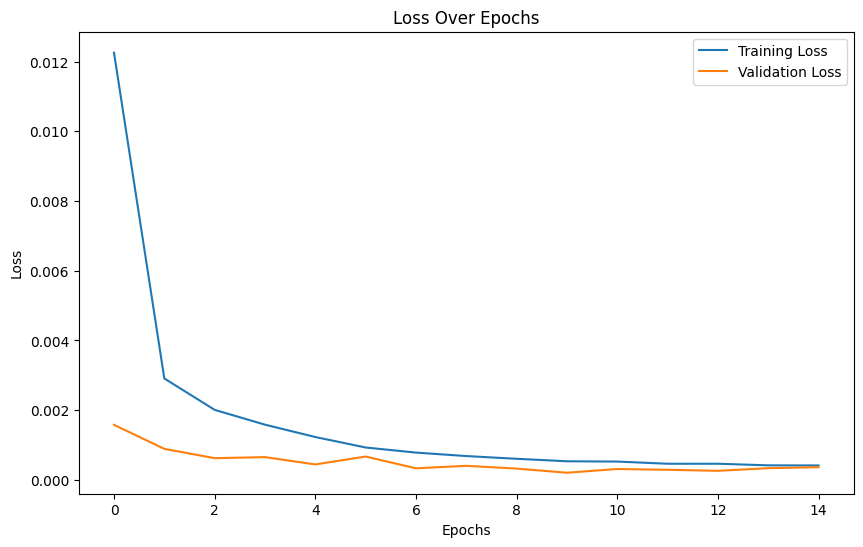

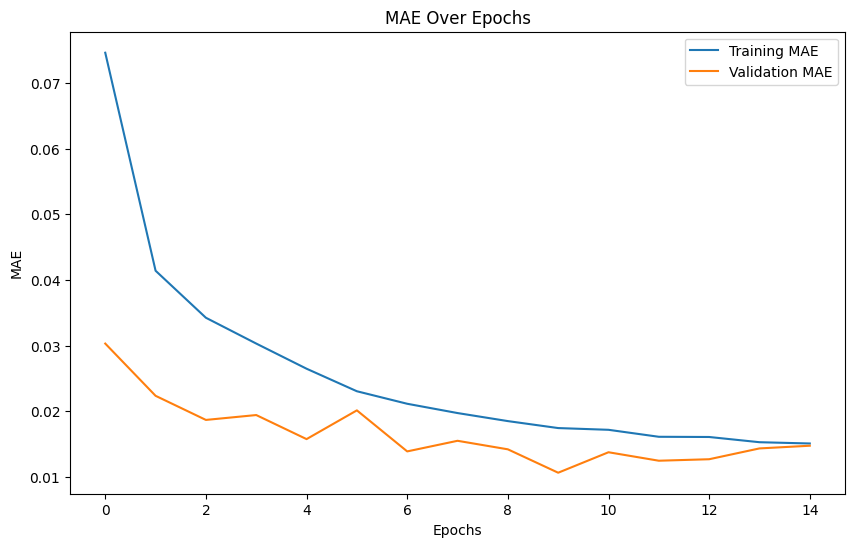

In [ ]:
#training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#training and validation MAE
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [ ]:
#predictions on the test set
y_pred = model.predict(X_test)

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [ ]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse}")

RMSE: 0.016339339315891266


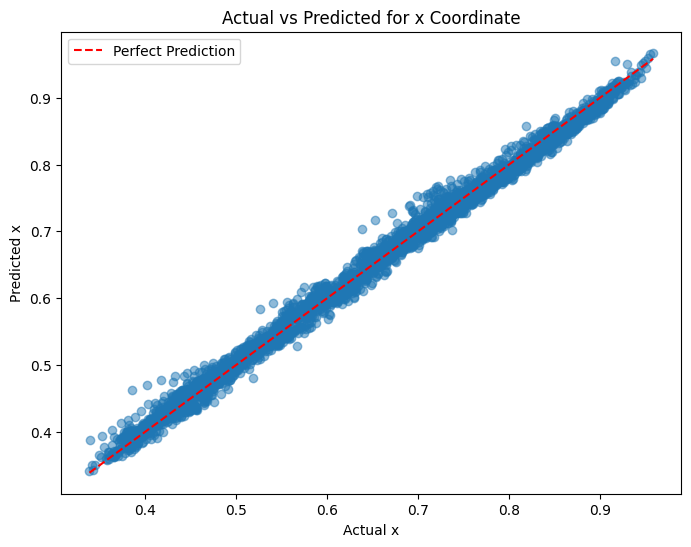

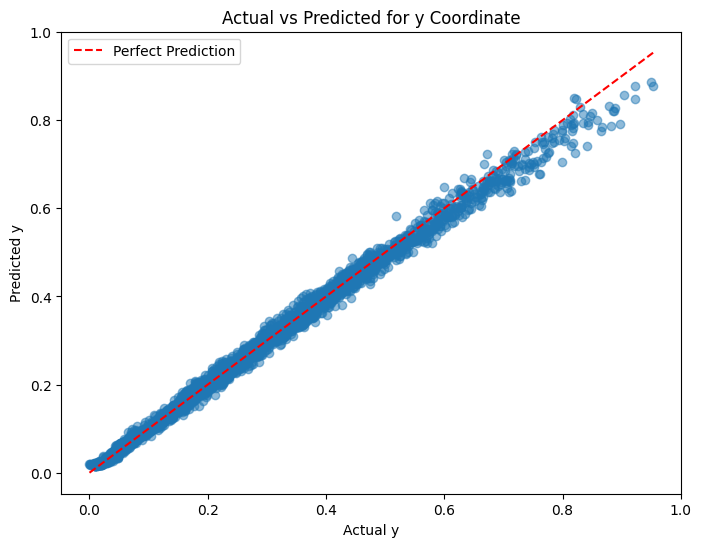

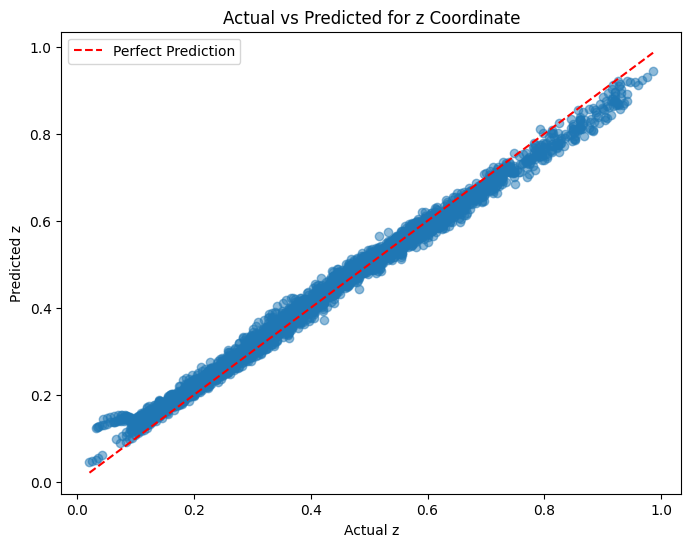

In [ ]:
#scatter plots for actual vs predicted for each coordinate
coordinates = ['x', 'y', 'z']

for i, coord in enumerate(coordinates):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test[:, i], y_pred[:, i], alpha=0.5)
    plt.plot([min(y_test[:, i]), max(y_test[:, i])], [min(y_test[:, i]), max(y_test[:, i])], color='red', linestyle='--', label='Perfect Prediction')
    plt.xlabel(f"Actual {coord}")
    plt.ylabel(f"Predicted {coord}")
    plt.title(f"Actual vs Predicted for {coord} Coordinate")
    plt.legend()
    plt.show()

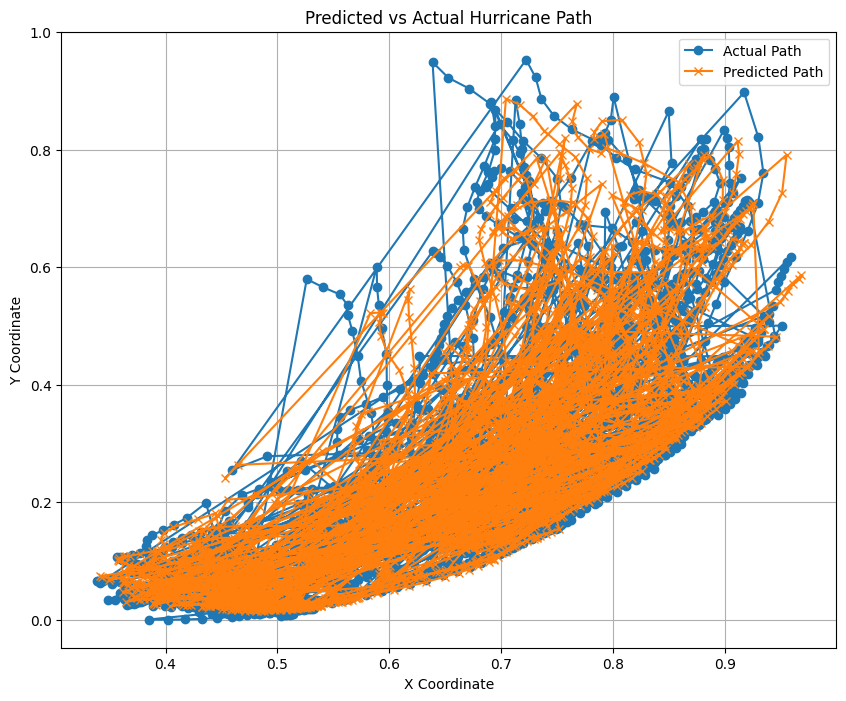

In [ ]:
#trajectory plot
plt.figure(figsize=(10, 8))
plt.plot(y_test[:, 0], y_test[:, 1], label='Actual Path', marker='o')  #actual trajectory (x, y)
plt.plot(y_pred[:, 0], y_pred[:, 1], label='Predicted Path', marker='x')  #predicted trajectory (x, y)
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Predicted vs Actual Hurricane Path")
plt.legend()
plt.grid()
plt.show()

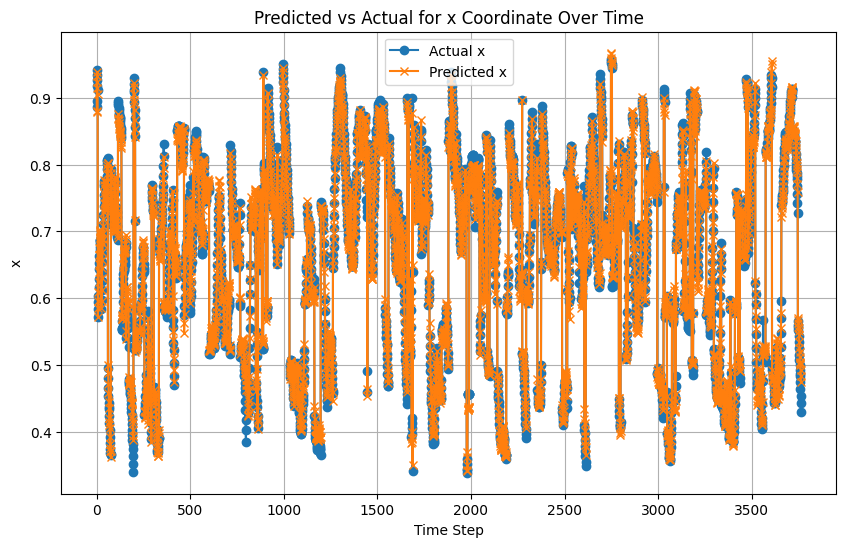

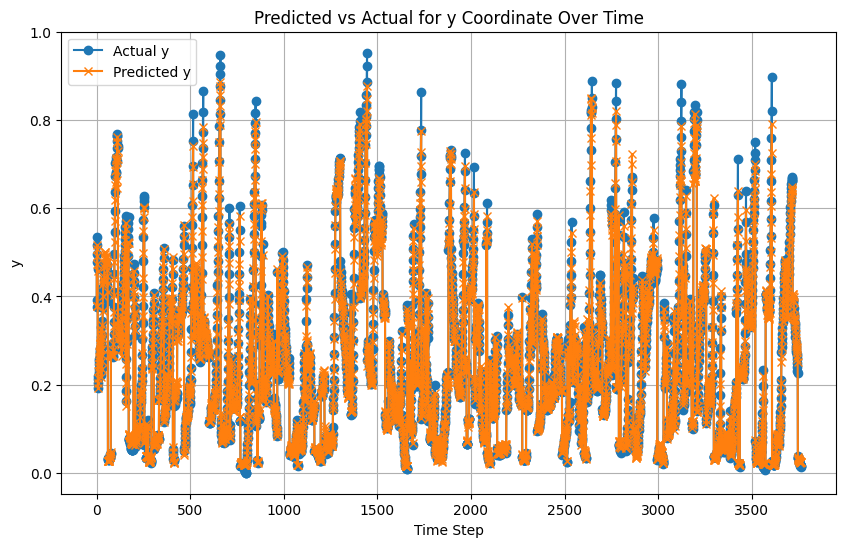

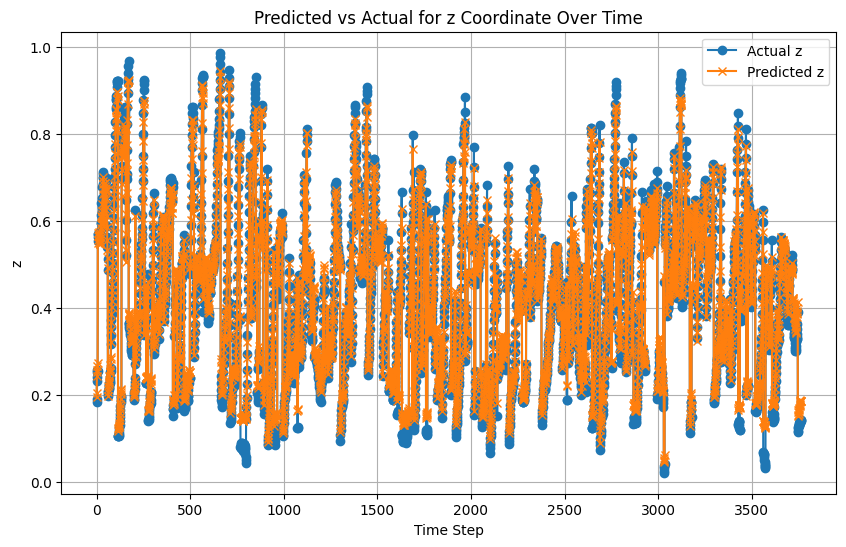

In [ ]:
#time series for a single hurricane
sample_index = 0  #first hurricane
timesteps = range(len(y_test))  #time indices

for i, coord in enumerate(coordinates):
    plt.figure(figsize=(10, 6))
    plt.plot(timesteps, y_test[:, i], label=f'Actual {coord}', marker='o')
    plt.plot(timesteps, y_pred[:, i], label=f'Predicted {coord}', marker='x')
    plt.xlabel("Time Step")
    plt.ylabel(coord)
    plt.title(f"Predicted vs Actual for {coord} Coordinate Over Time")
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
#separate predictions and actuals for each coordinate
x_pred, y_pred, z_pred = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]
x_true, y_true, z_true = y_test[:, 0], y_test[:, 1], y_test[:, 2]

#calc MAE and RMSE for each coordinate
mae_x = mean_absolute_error(x_true, x_pred)
mae_y = mean_absolute_error(y_true, y_pred)
mae_z = mean_absolute_error(z_true, z_pred)

rmse_x = np.sqrt(mean_squared_error(x_true, x_pred))
rmse_y = np.sqrt(mean_squared_error(y_true, y_pred))
rmse_z = np.sqrt(mean_squared_error(z_true, z_pred))

#calc R² for each coordinate
r2_x = r2_score(x_true, x_pred)
r2_y = r2_score(y_true, y_pred)
r2_z = r2_score(z_true, z_pred)

print(f"MAE (x): {mae_x}, MAE (y): {mae_y}, MAE (z): {mae_z}")
print(f"RMSE (x): {rmse_x}, RMSE (y): {rmse_y}, RMSE (z): {rmse_z}")
print(f"R² (x): {r2_x}, R² (y): {r2_y}, R² (z): {r2_z}")

MAE (x): 0.009271631948649883, MAE (y): 0.009699893184006214, MAE (z): 0.01732253096997738
RMSE (x): 0.012154897674918175, RMSE (y): 0.014399652369320393, RMSE (z): 0.02246345952153206
R² (x): 0.993156909942627, R² (y): 0.9939745664596558, R² (z): 0.9861631393432617


In [ ]:
#euclidean distance for each sample
distance_errors = np.sqrt(
    (x_true - x_pred)**2 + (y_true - y_pred)**2 + (z_true - z_pred)**2
)

#avg distance error
avg_distance_error = np.mean(distance_errors)
print(f"Average Euclidean Distance Error: {avg_distance_error}")

Average Euclidean Distance Error: 0.024575790390372276


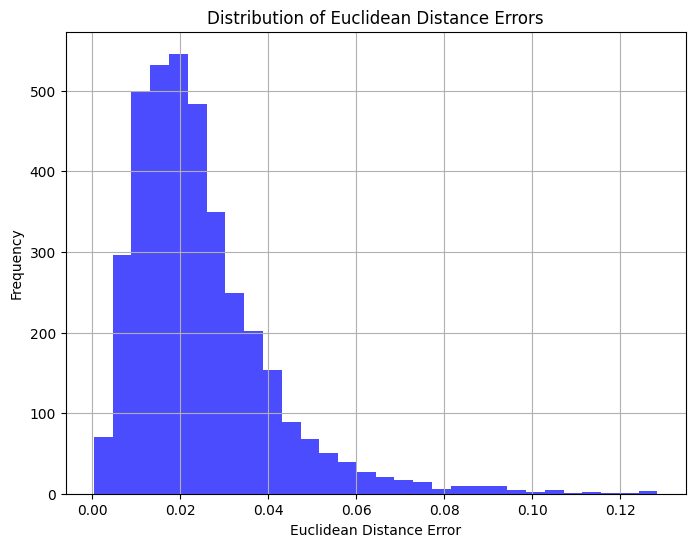

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(distance_errors, bins=30, alpha=0.7, color='blue')
plt.xlabel("Euclidean Distance Error")
plt.ylabel("Frequency")
plt.title("Distribution of Euclidean Distance Errors")
plt.grid()
plt.show()

In [ ]:
model.save('lstm_hurricane_model_path_prediction_3.keras')

#load the model
#model = tf.keras.models.load_model('lstm_hurricane_model_windprediction_1.h5')

#from tensorflow.keras.models import load_model

model.save('/content/drive/My Drive//ml31009_finalproject/lstm_hurricane_model_path_prediction_3.keras')

BIDIRECTIONAL LSTM

In [ ]:
#Bidirectional LSTM model
def build_bidirectional_lstm_model(input_shape, n_units=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Bidirectional(LSTM(units=n_units, return_sequences=True)))
    model.add(Dropout(dropout_rate))
    model.add(Bidirectional(LSTM(units=n_units, return_sequences=False)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=3))  # Output layer for x, y, z
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model

#input shape for the model
input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)

#build the model
bidirectional_model = build_bidirectional_lstm_model(input_shape)

#model summary
bidirectional_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 8, 128)              │          48,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 151,683 (592.51 KB)

 Trainable params: 151,683 (592.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = bidirectional_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0266 - mae: 0.1024 - val_loss: 8.9787e-04 - val_mae: 0.0230
Epoch 2/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0021 - mae: 0.0351 - val_loss: 4.9960e-04 - val_mae: 0.0169
Epoch 3/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0013 - mae: 0.0282 - val_loss: 3.4166e-04 - val_mae: 0.0145
Epoch 4/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 9.8410e-04 - mae: 0.0241 - val_loss: 3.8194e-04 - val_mae: 0.0154
Epoch 5/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 7.5896e-04 - mae: 0.0212 - val_loss: 0.0010 - val_mae: 0.0292
Epoch 6/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 6.4226e-04 - mae: 0.0193 - val_loss: 2.8927e-04 - val_mae: 0.0133
Epoch 7/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 5.3821e-04 - mae: 0.0175 - val_loss: 2.9386e-04 - val_mae: 0.0133
Epoch 8/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 4.6308e-04 - mae: 0.0163 - val_loss: 2.1101e-04 - val_mae: 0.0102


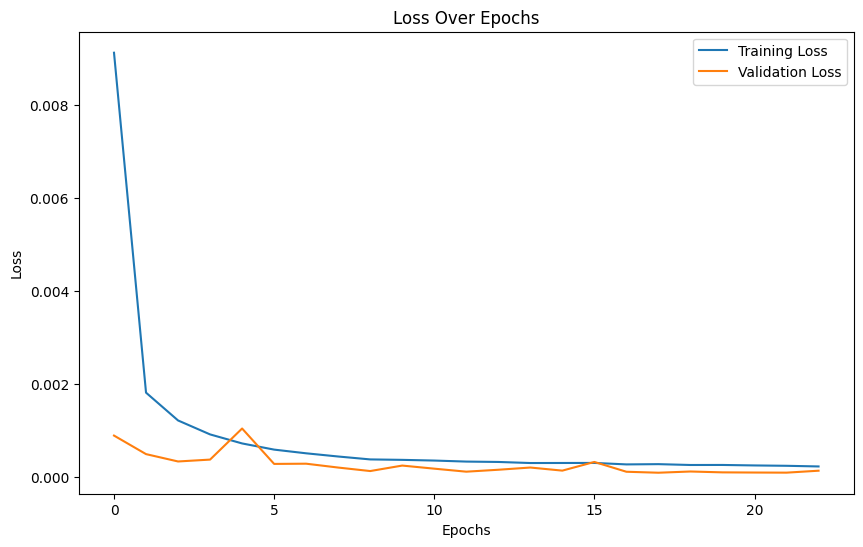

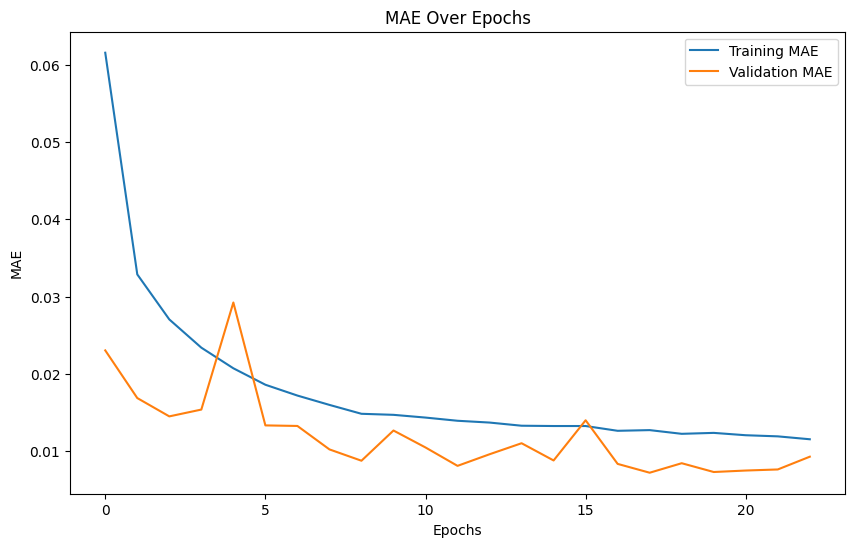

In [ ]:
#training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#training and validation MAE
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [ ]:
#eval the model on the test set
test_loss, test_mae = bidirectional_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0267e-04 - mae: 0.0075
Test Loss (MSE): 0.00011510582407936454
Test MAE: 0.007942300289869308


In [ ]:
#predictions
y_pred_bidirectional = bidirectional_model.predict(X_test)
y_pred_bidirectional.shape

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


(3764, 3)

In [ ]:
#per coordinate evaluation
coordinates = ['x', 'y', 'z']
mae_per_coord = np.mean(np.abs(y_pred_bidirectional - y_test), axis=0)
rmse_per_coord = np.sqrt(np.mean((y_pred_bidirectional - y_test) ** 2, axis=0))
r2_per_coord = [
    r2_score(y_test[:, i], y_pred_bidirectional[:, i]) for i in range(len(coordinates))
]

#metrics
for i, coord in enumerate(coordinates):
    print(f"{coord.upper()} - MAE: {mae_per_coord[i]:.4f}, RMSE: {rmse_per_coord[i]:.4f}, R²: {r2_per_coord[i]:.4f}")

#avg Euclidean Distance Error
avg_euclidean_error = np.mean(np.sqrt(np.sum((y_pred_bidirectional - y_test) ** 2, axis=1)))
print(f"Average Euclidean Distance Error: {avg_euclidean_error:.4f}")

X - MAE: 0.0064, RMSE: 0.0085, R²: 0.9966
Y - MAE: 0.0074, RMSE: 0.0100, R²: 0.9971
Z - MAE: 0.0101, RMSE: 0.0131, R²: 0.9953
Average Euclidean Distance Error: 0.0158


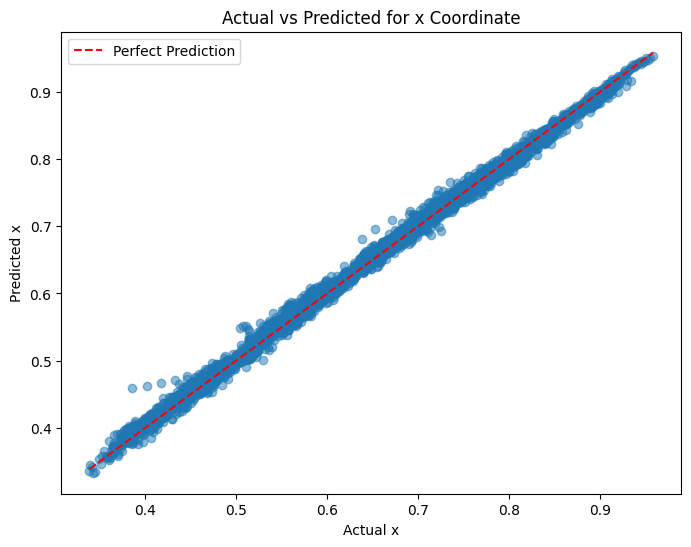

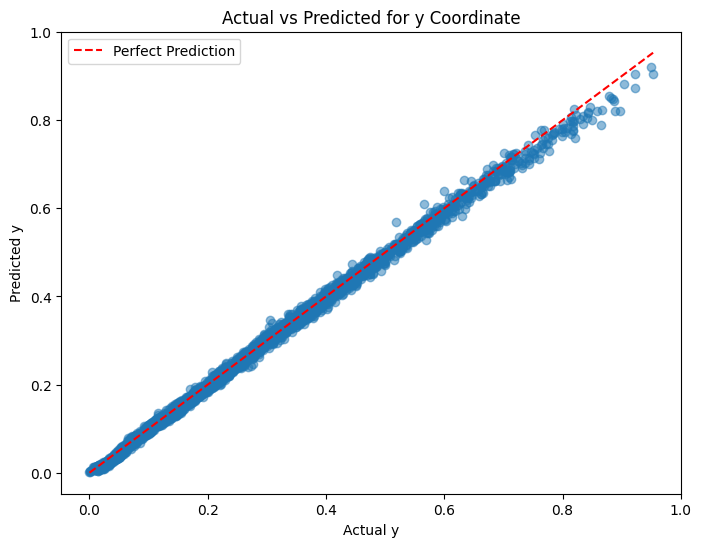

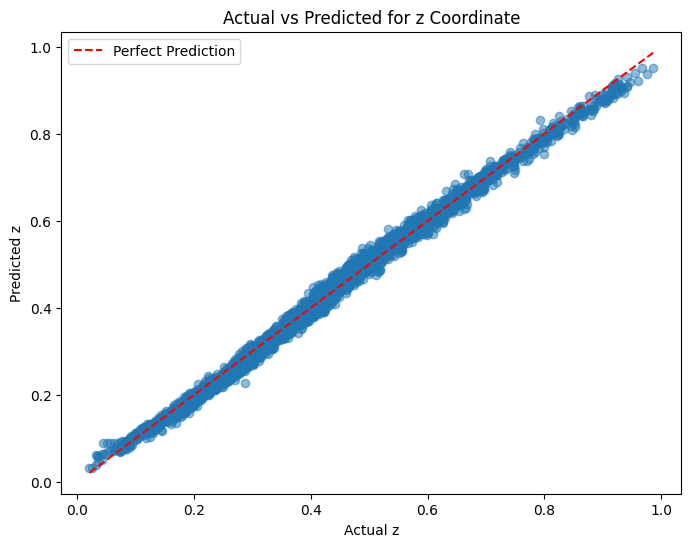

In [ ]:
#plots for actual vs predicted for each coordinate
#coordinates = ['x', 'y', 'z']

for i, coord in enumerate(coordinates):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test[:, i], y_pred_bidirectional[:, i], alpha=0.5)
    plt.plot([min(y_test[:, i]), max(y_test[:, i])], [min(y_test[:, i]), max(y_test[:, i])], color='red', linestyle='--', label='Perfect Prediction')
    plt.xlabel(f"Actual {coord}")
    plt.ylabel(f"Predicted {coord}")
    plt.title(f"Actual vs Predicted for {coord} Coordinate")
    plt.legend()
    plt.show()

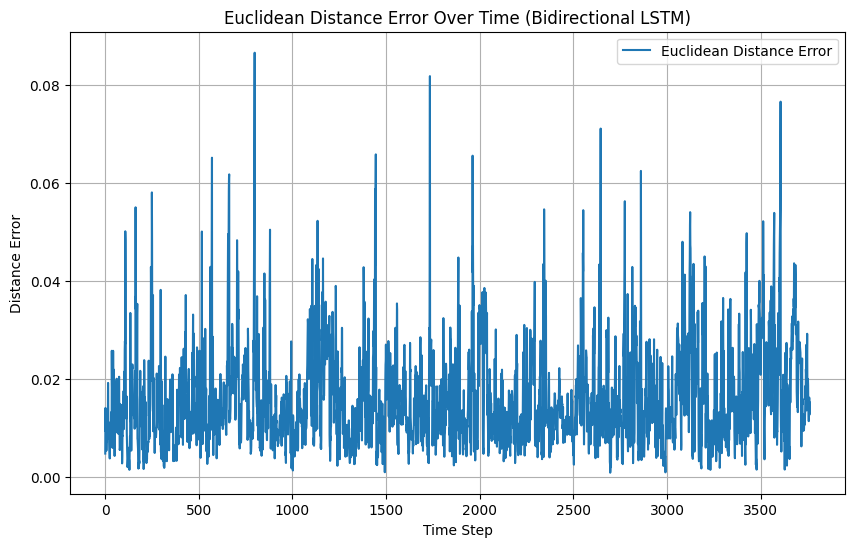

In [ ]:
#Euclidean distance over timesteps
euclidean_distance = np.sqrt(np.sum((y_pred_bidirectional - y_test) ** 2, axis=1))
plt.figure(figsize=(10, 6))
plt.plot(euclidean_distance, label="Euclidean Distance Error")
plt.xlabel("Time Step")
plt.ylabel("Distance Error")
plt.title("Euclidean Distance Error Over Time (Bidirectional LSTM)")
plt.legend()
plt.grid()
plt.show()

In [ ]:
#separate predictions and actuals for each coordinate
x_pred_bidirectional, y_pred_bidirectional, z_pred_bidirectional = y_pred_bidirectional[:, 0], y_pred_bidirectional[:, 1], y_pred_bidirectional[:, 2]
x_true, y_true, z_true = y_test[:, 0], y_test[:, 1], y_test[:, 2]

#calc MAE and RMSE for each coordinate
mae_x = mean_absolute_error(x_true, x_pred_bidirectional)
mae_y = mean_absolute_error(y_true, y_pred_bidirectional)
mae_z = mean_absolute_error(z_true, z_pred_bidirectional)

rmse_x = np.sqrt(mean_squared_error(x_true, x_pred_bidirectional))
rmse_y = np.sqrt(mean_squared_error(y_true, y_pred_bidirectional))
rmse_z = np.sqrt(mean_squared_error(z_true, z_pred_bidirectional))

# calc r2 for each coordinate
r2_x = r2_score(x_true, x_pred_bidirectional)
r2_y = r2_score(y_true, y_pred_bidirectional)
r2_z = r2_score(z_true, z_pred_bidirectional)

print(f"MAE (x): {mae_x}, MAE (y): {mae_y}, MAE (z): {mae_z}")
print(f"RMSE (x): {rmse_x}, RMSE (y): {rmse_y}, RMSE (z): {rmse_z}")
print(f"R² (x): {r2_x}, R² (y): {r2_y}, R² (z): {r2_z}")

MAE (x): 0.006360298953950405, MAE (y): 0.00737291993573308, MAE (z): 0.010093688033521175
RMSE (x): 0.00854500476270914, RMSE (y): 0.01004568487405777, RMSE (z): 0.013091398403048515
R² (x): 0.9966180324554443, R² (y): 0.9970674514770508, R² (z): 0.9953004717826843


In [ ]:
#euclidean distance for each sample
distance_errors_bidirectional = np.sqrt(
    (x_true - x_pred_bidirectional)**2 + (y_true - y_pred_bidirectional)**2 + (z_true - z_pred_bidirectional)**2
)

#avg distance error
avg_distance_error_bidirectional = np.mean(distance_errors_bidirectional)
print(f"Average Euclidean Distance Error: {avg_distance_error}")

Average Euclidean Distance Error: 0.024575790390372276


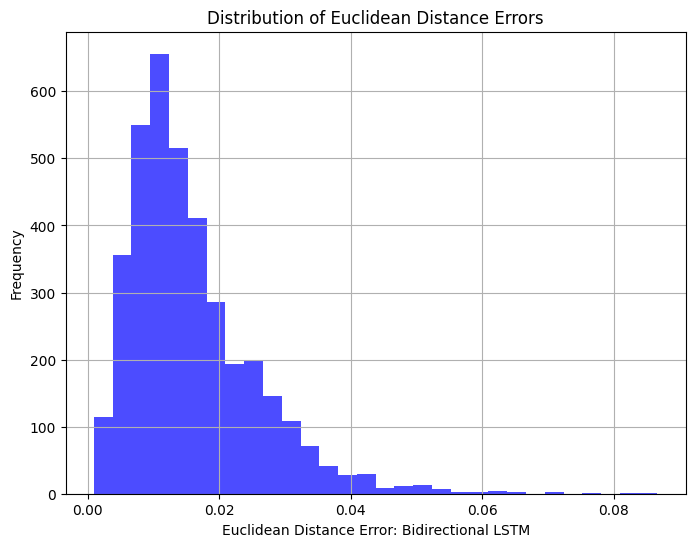

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(distance_errors_bidirectional, bins=30, alpha=0.7, color='blue')
plt.xlabel("Euclidean Distance Error: Bidirectional LSTM")
plt.ylabel("Frequency")
plt.title("Distribution of Euclidean Distance Errors")
plt.grid()
plt.show()

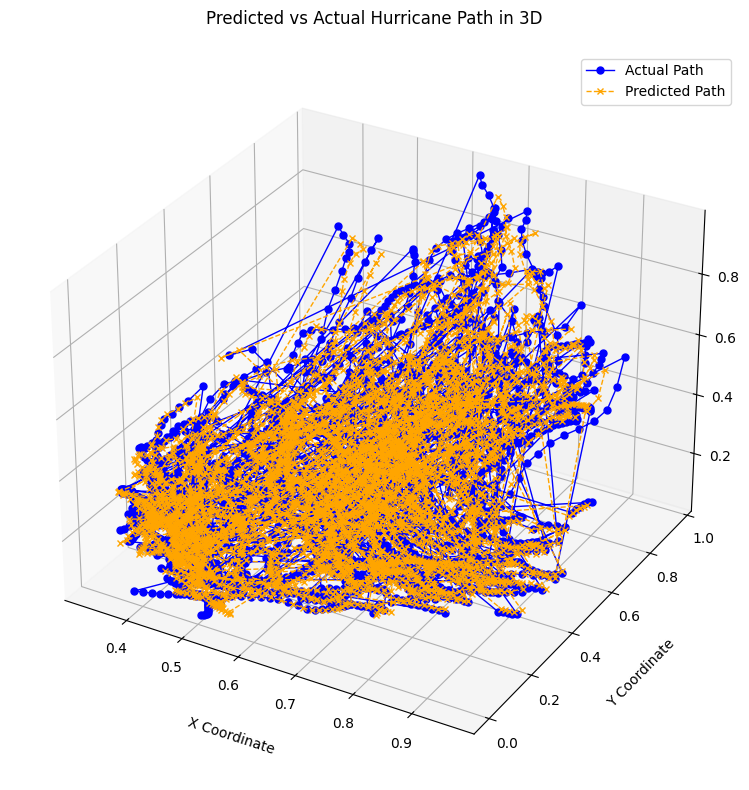

In [ ]:
3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

#actual trajectory
ax.plot(y_test[:, 0], y_test[:, 1], y_test[:, 2], label='Actual Path', marker='o', linestyle='-', linewidth=1, markersize=5, color='blue')

#predicted trajectory
ax.plot(y_pred_bidirectional[:, 0], y_pred_bidirectional[:, 1], y_pred_bidirectional[:, 2], label='Predicted Path', marker='x', linestyle='--', linewidth=1, markersize=5, color='orange')

#labels with padding
ax.set_xlabel("X Coordinate", labelpad=15)
ax.set_ylabel("Y Coordinate", labelpad=15)
ax.set_zlabel("Z Coordinate", labelpad=15)
ax.set_title("Predicted vs Actual Hurricane Path in 3D", pad=20)

#legend and grid
ax.legend()
ax.grid()


plt.tight_layout()  #auto adjust padding
plt.show()

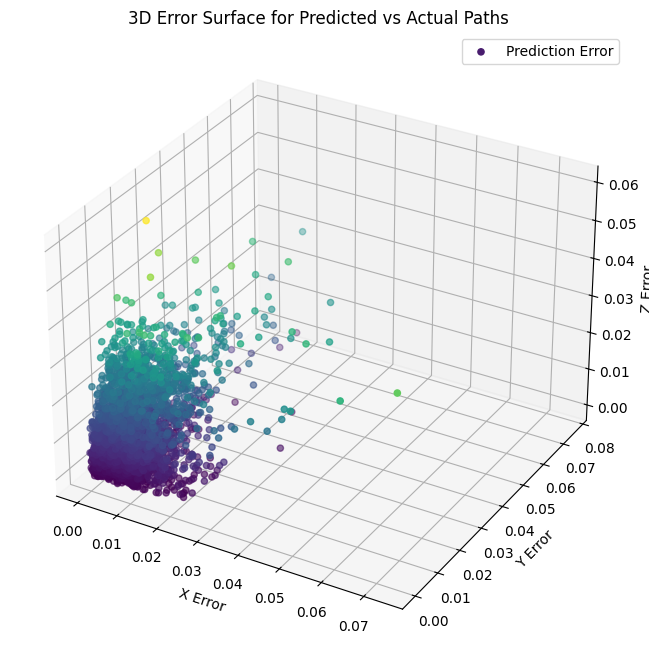

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

#compute errors
x_error = np.abs(y_test[:, 0] - y_pred_bidirectional[:, 0])
y_error = np.abs(y_test[:, 1] - y_pred_bidirectional[:, 1])
z_error = np.abs(y_test[:, 2] - y_pred_bidirectional[:, 2])

#errors in 3D space
ax.scatter(x_error, y_error, z_error, c=z_error, cmap='viridis', label='Prediction Error')
ax.set_xlabel("X Error")
ax.set_ylabel("Y Error")
ax.set_zlabel("Z Error")
ax.set_title("3D Error Surface for Predicted vs Actual Paths")
ax.legend()
plt.show()

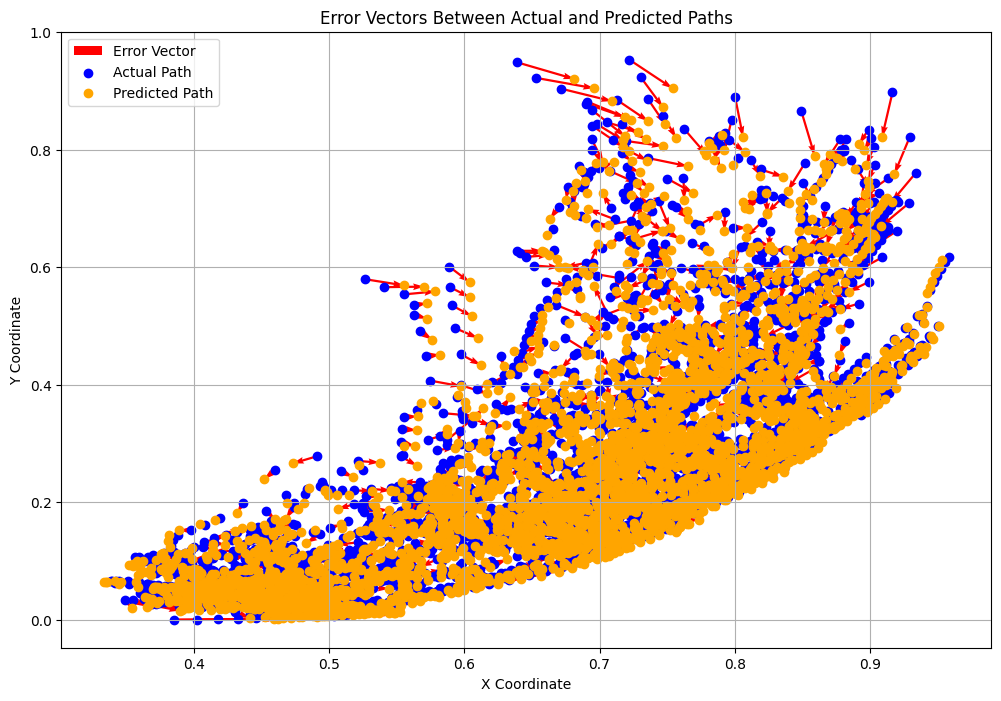

In [ ]:
plt.figure(figsize=(12, 8))
plt.quiver(y_test[:, 0], y_test[:, 1], y_pred_bidirectional[:, 0] - y_test[:, 0], y_pred_bidirectional[:, 1] - y_test[:, 1],
           angles='xy', scale_units='xy', scale=1, color='r', label='Error Vector')
plt.scatter(y_test[:, 0], y_test[:, 1], label='Actual Path', color='blue')
plt.scatter(y_pred_bidirectional[:, 0], y_pred_bidirectional[:, 1], label='Predicted Path', color='orange')
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Error Vectors Between Actual and Predicted Paths")
plt.legend()
plt.grid()
plt.show()

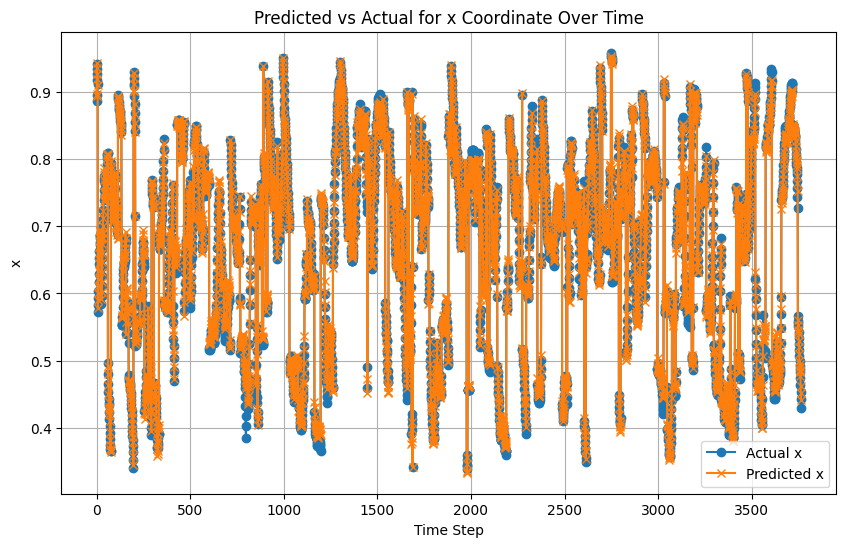

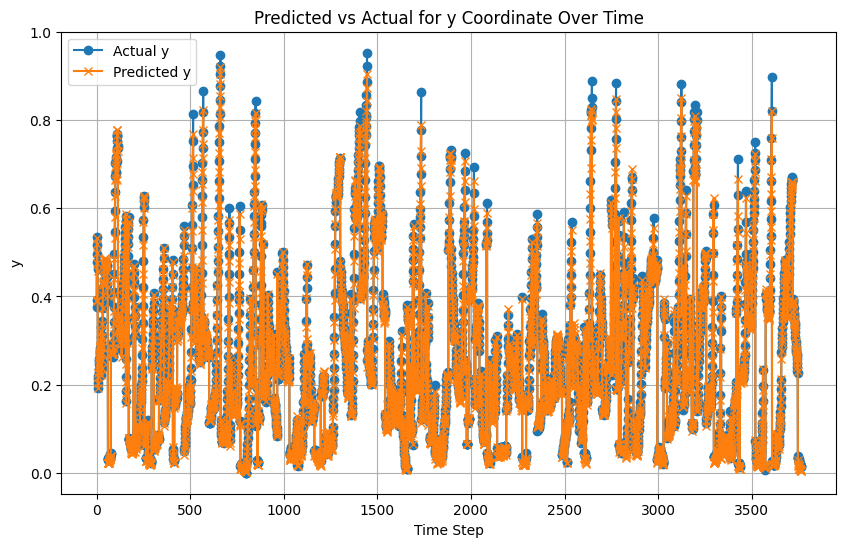

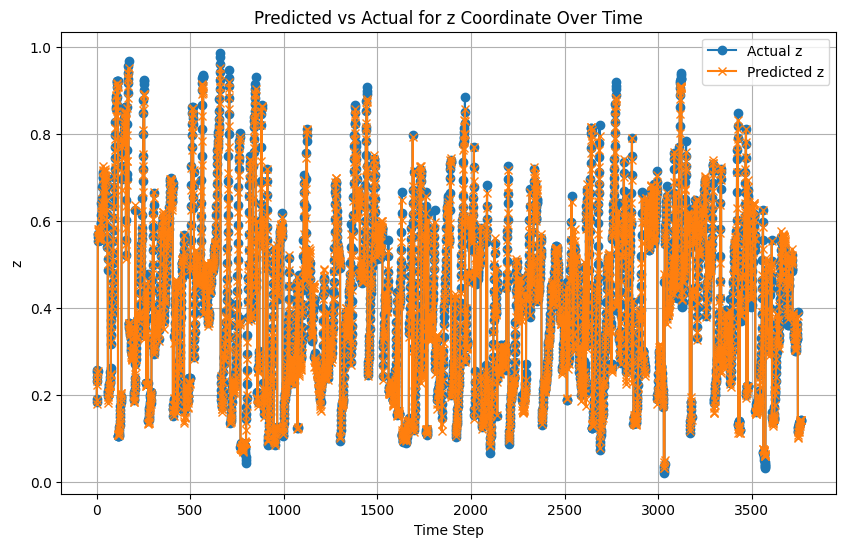

In [ ]:
#time series for a single hurricane
sample_index = 0  #first hurricane
timesteps = range(len(y_test))  #time indices

for i, coord in enumerate(coordinates):
    plt.figure(figsize=(10, 6))
    plt.plot(timesteps, y_test[:, i], label=f'Actual {coord}', marker='o')
    plt.plot(timesteps, y_pred_bidirectional[:, i], label=f'Predicted {coord}', marker='x')
    plt.xlabel("Time Step")
    plt.ylabel(coord)
    plt.title(f"Predicted vs Actual for {coord} Coordinate Over Time")
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
metrics_df = pd.DataFrame({
    'Coordinate': ['X', 'Y', 'Z', 'Euclidean'],
    'MAE': [mae_x, mae_y, mae_z, avg_distance_error],
    'RMSE': [rmse_x, rmse_y, rmse_z, np.sqrt(np.mean(distance_errors**2))],
    'R²': [r2_x, r2_y, r2_z, '-']  # R² not applicable for Euclidean
})
print(metrics_df)

  Coordinate       MAE      RMSE        R²
0          X  0.006360  0.008545  0.996618
1          Y  0.007373  0.010046  0.997067
2          Z  0.010094  0.013091    0.9953
3  Euclidean  0.024576  0.029321         -


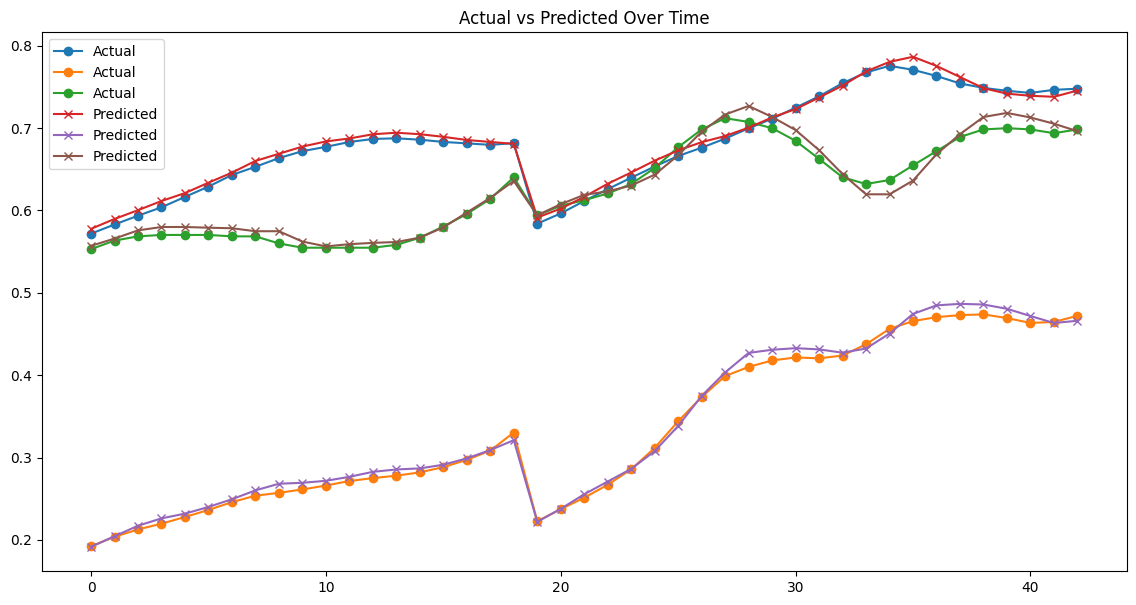

In [ ]:
#uses the first 50 predictions (y_test[:50] and y_pred[:50])
#y_test scaled vs. y_pred
#x axis ordered based upon sequence (time ordered)
plt.figure(figsize=(14, 7))
plt.plot(y_test[7:50], label='Actual', marker='o')  # Use a subset for clarity
plt.plot(y_pred_bidirectional[7:50], label='Predicted', marker='x')
plt.legend()
plt.title('Actual vs Predicted Over Time')
plt.show()

In [ ]:
#filename for the image
file_name = "bidirectional_lstm_model.png"

#path to save the image in Google Drive
file_path = os.path.join(folder_path, file_name)

#gen and save the model plot
plot_model(model, to_file=file_path, show_shapes=True, show_layer_names=True)

print(f"Model visualization saved at: {file_path}")

Model visualization saved at: /content/drive/My Drive/ml31009_finalproject/bidirectional_lstm_model.png


In [ ]:
model.save('bidirectional_lstm_hurricane_model_path_prediction_2.keras')
#load the model
#model = tf.keras.models.load_model('lstm_hurricane_model_windprediction_1.h5')

#from tensorflow.keras.models import load_model

model.save('/content/drive/My Drive//ml31009_finalproject/bidirectional_lstm_hurricane_model_path_prediction_2.keras')

GRU MODEL

In [ ]:
#GRU model
def build_gru_model(input_shape, n_units=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(GRU(units=n_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(GRU(units=n_units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=3))  #output layer for x, y, z
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model

#input shape for the model
input_shape = (X_train.shape[1], X_train.shape[2])  #(timesteps, features)

#build
gru_model = build_gru_model(input_shape)


gru_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 8, 64)               │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 8, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,571 (178.01 KB)

 Trainable params: 45,571 (178.01 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#train the GRU model
history = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0305 - mae: 0.1185 - val_loss: 0.0019 - val_mae: 0.0342
Epoch 2/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0036 - mae: 0.0462 - val_loss: 7.5540e-04 - val_mae: 0.0212
Epoch 3/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0022 - mae: 0.0362 - val_loss: 4.7346e-04 - val_mae: 0.0166
Epoch 4/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0016 - mae: 0.0311 - val_loss: 4.1344e-04 - val_mae: 0.0158
Epoch 5/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0012 - mae: 0.0266 - val_loss: 3.2921e-04 - val_mae: 0.0139
Epoch 6/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 9.5054e-04 - mae: 0.0234 - val_loss: 2.4527e-04 - val_mae: 0.0120
Epoch 7/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 8.2136e-04 - mae: 0.0218 - val_loss: 2.0916e-04 - val_mae: 0.0109
Epoch 8/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 7.0818e-04 - mae: 0.0202 - val_loss: 2.0934e-04 - val_mae: 0.0111
Epoch 9/50
353

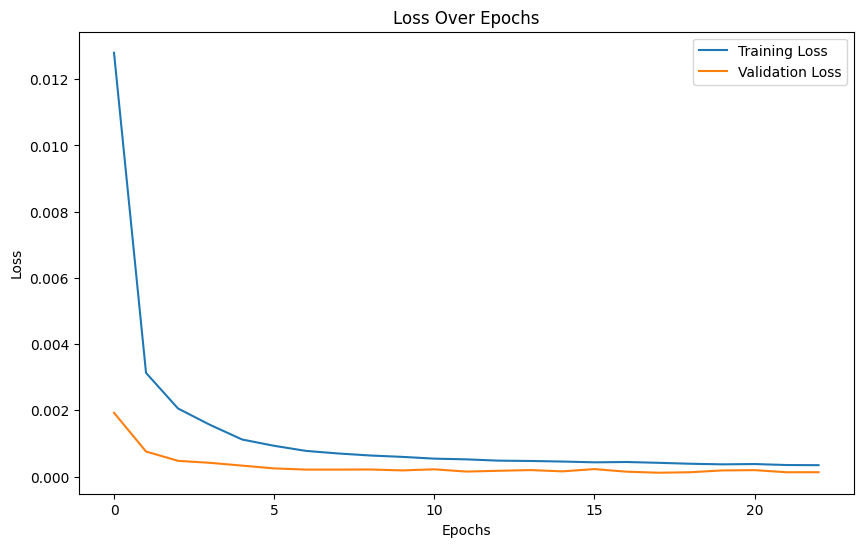

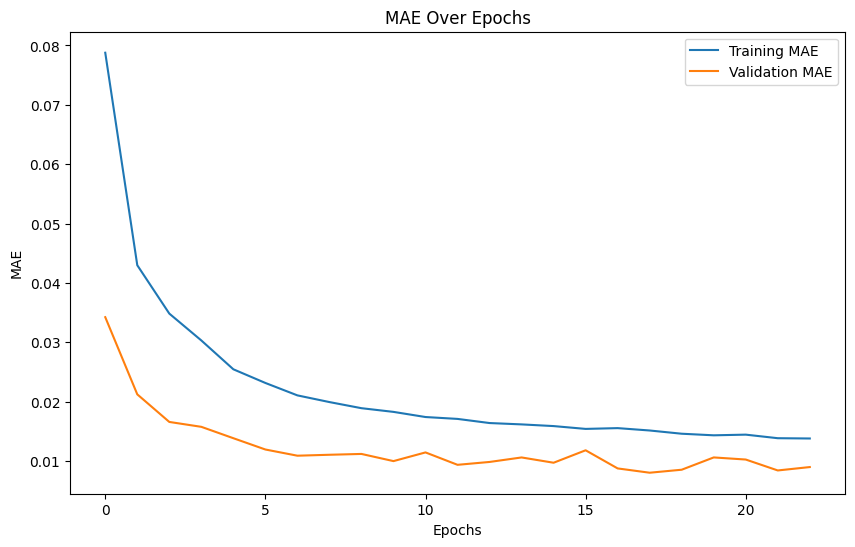

In [ ]:
#training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#training and validation MAE
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [ ]:
#eval the model
test_loss, test_mae = gru_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2857e-04 - mae: 0.0085
Test Loss (MSE): 0.00013038030010648072
Test MAE: 0.008478316478431225


In [ ]:
#predictions
y_pred_gru = gru_model.predict(X_test)

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:
#seeparate predictions into coordinates
x_pred, y_pred, z_pred = y_pred_gru[:, 0], y_pred_gru[:, 1], y_pred_gru[:, 2]
x_true, y_true, z_true = y_test[:, 0], y_test[:, 1], y_test[:, 2]

#each coordinate
mae_x = np.mean(np.abs(x_true - x_pred))
mae_y = np.mean(np.abs(y_true - y_pred))
mae_z = np.mean(np.abs(z_true - z_pred))

rmse_x = np.sqrt(mean_squared_error(x_true, x_pred))
rmse_y = np.sqrt(mean_squared_error(y_true, y_pred))
rmse_z = np.sqrt(mean_squared_error(z_true, z_pred))

r2_x = r2_score(x_true, x_pred)
r2_y = r2_score(y_true, y_pred)
r2_z = r2_score(z_true, z_pred)

#avg Euclidean distance error
distance_errors = np.sqrt((x_true - x_pred)**2 + (y_true - y_pred)**2 + (z_true - z_pred)**2)
avg_distance_error = np.mean(distance_errors)

print(f"MAE (x): {mae_x:.4f}, MAE (y): {mae_y:.4f}, MAE (z): {mae_z:.4f}")
print(f"RMSE (x): {rmse_x:.4f}, RMSE (y): {rmse_y:.4f}, RMSE (z): {rmse_z:.4f}")
print(f"R² (x): {r2_x:.4f}, R² (y): {r2_y:.4f}, R² (z): {r2_z:.4f}")
print(f"Average Euclidean Distance Error: {avg_distance_error:.4f}")


MAE (x): 0.0069, MAE (y): 0.0080, MAE (z): 0.0105
RMSE (x): 0.0088, RMSE (y): 0.0116, RMSE (z): 0.0134
R² (x): 0.9964, R² (y): 0.9961, R² (z): 0.9951
Average Euclidean Distance Error: 0.0169


MULTITASK LSTM FOR BOTH WIND AND PATH

In [ ]:
#input and target features
input_features = [
    'duration_hours', 'trajectory_distance_km',
    'x', 'y', 'z', 'U', 'V', 'DVMX',
    'min_pressure', 'max_wind_speed', 'delta_wind',
    'year', 'month', 'day', 'hour',
    'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4',
    'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9',
    'cluster_10', 'cluster_11', 'cluster_12', 'cluster_13', 'cluster_14'
]

target_features = ['max_wind_speed', 'x', 'y', 'z']


scaler = MinMaxScaler()
storm_data_df[input_features] = scaler.fit_transform(storm_data_df[input_features])

#sequences for the combined model
def create_sequences(df, input_features, target_features, n_timesteps):
    X, y = [], []
    for storm_id, group in df.groupby('storm_id'):
        group = group.sort_values('datetime')
        input_data = group[input_features].values
        target_data = group[target_features].values

        for i in range(len(input_data) - n_timesteps):
            X.append(input_data[i:i + n_timesteps])  #input sequence
            y.append(target_data[i + n_timesteps])  #target (next step)

    return np.array(X), np.array(y)


n_timesteps = 5

#create sequences and targets
X, y = create_sequences(storm_data_df, input_features, target_features, n_timesteps)

#train-validation-test split for time series
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)
test_size = len(X) - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

#convert to float32
X_train, X_val, X_test = map(lambda data: data.astype('float32'), [X_train, X_val, X_test])
y_train, y_val, y_test = map(lambda data: data.astype('float32'), [y_train, y_val, y_test])

In [ ]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (31509, 5, 30)
X_val shape: (6751, 5, 30)
X_test shape: (6753, 5, 30)
y_train shape: (31509, 4)
y_val shape: (6751, 4)
y_test shape: (6753, 4)


In [ ]:
#combined LSTM model
def build_combined_model(input_shape, n_units=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units=n_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=n_units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=4))  #output layer for windspeed, x, y, z
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model

In [ ]:
#input shape for the model
input_shape = (X_train.shape[1], X_train.shape[2])

#build and compile the model
combined_model = build_combined_model(input_shape)

#def early stop
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#train
history = combined_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
985/985 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0146 - mae: 0.0786 - val_loss: 0.0015 - val_mae: 0.0238
Epoch 2/50
985/985 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0018 - mae: 0.0305 - val_loss: 8.9046e-04 - val_mae: 0.0189
Epoch 3/50
985/985 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0012 - mae: 0.0242 - val_loss: 5.6470e-04 - val_mae: 0.0149
Epoch 4/50
985/985 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 9.4050e-04 - mae: 0.0217 - val_loss: 4.8887e-04 - val_mae: 0.0142
Epoch 5/50
985/985 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 8.1667e-04 - mae: 0.0202 - val_loss: 5.0863e-04 - val_mae: 0.0139
Epoch 6/50
985/985 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 7.9059e-04 - mae: 0.0196 - val_loss: 4.4660e-04 - val_mae: 0.0129
Epoch 7/50
985/985 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 7.5750e-04 - mae: 0.0193 - val_loss: 4.9411e-04 - val_mae: 0.0147
Epoch 8/50
985/985 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 7.5061e-04 - mae: 0.0189 - val_loss: 4.4801e-04 - val_mae: 0.0131
Epoch

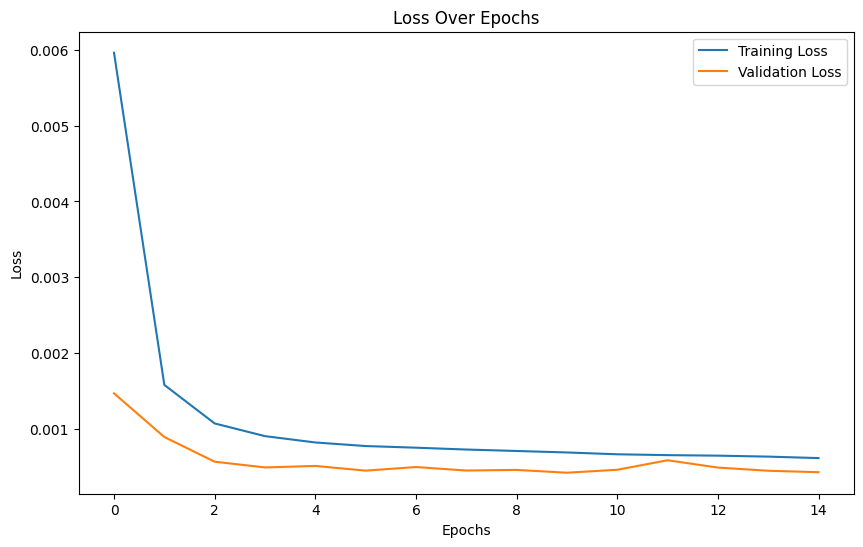

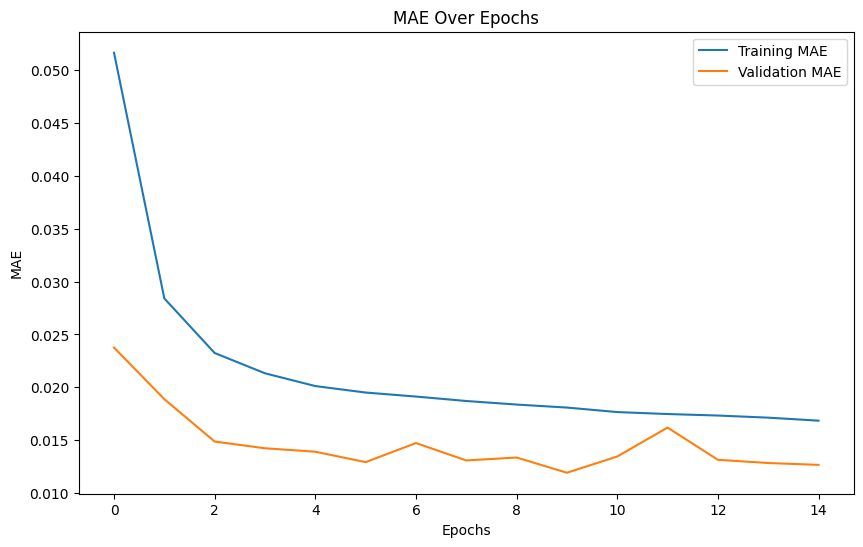

In [ ]:
#training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#training and validation MAE
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [ ]:
#eval model on the test set
test_loss, test_mae = combined_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")

#predictions
y_pred = combined_model.predict(X_test)

#metrics for windspeed and path separately
windspeed_mae = np.mean(np.abs(y_test[:, 0] - y_pred[:, 0]))
path_mae = np.mean(np.abs(y_test[:, 1:] - y_pred[:, 1:]), axis=0)  # MAE for x, y, z separately
print(f"MAE (Windspeed): {windspeed_mae}")
print(f"MAE (Path): x: {path_mae[0]}, y: {path_mae[1]}, z: {path_mae[2]}")

212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.2661e-04 - mae: 0.0117
Test Loss (MSE): 0.0004737075068987906
Test MAE: 0.011876184493303299
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MAE (Windspeed): 0.022446488961577415
MAE (Path): x: 0.007141145411878824, y: 0.007760034408420324, z: 0.010157078504562378
